We will be working on the built in MNIST Tensorflow dataset, this dataset contains 70000 images of handwritten from 0 to 9, each image is in 28x28 dimension in grayscale only.It has been split into 60000 train set and 10000 test set, for that we will need to create a validation dataset to set early stopping mechanism and pervent overfitting.

#### The plan 
- first we will be using a convolutional layer with kernel size 5x5 and 50 kernels(we won't use a dense layer as that would unpack the 2D image to 1D vector which is far from our desired result) with the ReLu as activation function as it behaves well in most situations.
- Our second layer would be a maxpool layer and have a 2x2 kernels with stride 2
then we will redo the two layers with a kernel of 3x3 for the convolution and a 50 kernels.
then we will flatten the vector (5x5x50) into a 1250 vector and put it into a dense layer that corresponds to 10 digits we want to classify with softmax activation function.

### Importing relevant libraries 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime

C:\Users\zinel\anaconda3\envs\py3-TF2.0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
buffer_size=70_000#the maximum batch for shuffling the dataset
batch_size=128
epochs=20

In [3]:
data,info=tfds.load(name='mnist',with_info=True,as_supervised=True)

In [4]:
train,test=data['train'],data['test']

### Scaling the data [0,1]

In [5]:
def scale(image,label):
    image=tf.cast(image,tf.float32)
    image/=255.
    return image,label

    

In [6]:
train_and_validation_data=train.map(scale)
test_data=test.map(scale)

### Creating validation set

In [7]:
num_validation_samples = 0.1*info.splits['train'].num_examples
num_validation_samples=tf.cast(num_validation_samples,tf.int64)

In [8]:
num_test_samples=info.splits['test'].num_examples
num_test_samples=tf.cast(num_test_samples,tf.int64)

In [9]:
#quick shuffle before split
train_and_validation_data=train_and_validation_data.shuffle(buffer_size)

In [10]:
train_data=train_and_validation_data.skip(num_validation_samples)

In [11]:
validation_data=train_and_validation_data.take(num_validation_samples)

In [12]:
#batching the data, preferable a power of 2
train_data=train_data.batch(batch_size)
# the validation and test sets don't need to be batched as we don't backpropagate on them
#but the model expects them to be batched as well to get the proper dimension with their number of samples
validation_data=validation_data.batch(num_validation_samples)
test_data=test_data.batch(num_test_samples)

### Outlining the model 

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50,5,activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(50,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
    
])

In [14]:
model.summary(line_length=75) #to check if the model works properly

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [15]:
# for classification problems we need the sparseCategoricalCrossEntropy loss function
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# this would be the loss function if we had a softmax activation
# we avoid inserting the softmax in the model for numerical stability

In [2]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

NameError: name 'model' is not defined

Now we should setup an early stopping mechanism to avoid overfitting, in tensorflow this is done using callbacks, callbacks are executed at the end of aech epoch:

In [17]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',#indicates which property to monitor during training
    mode='auto',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

In [18]:
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
model.fit(
    train_data,
    epochs=epochs,
    callbacks=[tensorboard_callback,early_stopping],#always keep the early stopping the last element of the list, otherwise it bugs out
    validation_data=validation_data,
    verbose=2
)

Epoch 1/20
422/422 - 68s - loss: 0.2653 - accuracy: 0.9258 - val_loss: 0.0897 - val_accuracy: 0.9748 - 68s/epoch - 160ms/step
Epoch 2/20
422/422 - 55s - loss: 0.0739 - accuracy: 0.9777 - val_loss: 0.0505 - val_accuracy: 0.9835 - 55s/epoch - 130ms/step
Epoch 3/20
422/422 - 68s - loss: 0.0534 - accuracy: 0.9842 - val_loss: 0.0463 - val_accuracy: 0.9853 - 68s/epoch - 162ms/step
Epoch 4/20
422/422 - 63s - loss: 0.0448 - accuracy: 0.9866 - val_loss: 0.0351 - val_accuracy: 0.9895 - 63s/epoch - 150ms/step
Epoch 5/20
422/422 - 50s - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0331 - val_accuracy: 0.9892 - 50s/epoch - 119ms/step
Epoch 6/20
422/422 - 48s - loss: 0.0322 - accuracy: 0.9900 - val_loss: 0.0256 - val_accuracy: 0.9918 - 48s/epoch - 113ms/step
Epoch 7/20
422/422 - 48s - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.0218 - val_accuracy: 0.9927 - 48s/epoch - 113ms/step
Epoch 8/20
422/422 - 47s - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.0188 - val_accuracy: 0.9935 - 47s/epoch - 112

### Test Data

In [20]:
test_loss,test_accuracy=model.evaluate(test_data)

1/1 [==============================] - 5s 5s/step - loss: 0.0281 - accuracy: 0.9914


Pretty good accuracy, good job soldier.

### Plotting images and the results

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
#split yhe test_data into 2 arrays, containing the images and the corresponding labels
for images,labels in test_data.take(1):
    images_test=images.numpy()
    labels_test=labels.numpy()
    
#rehape the images into 28x28
images_plot=np.reshape(images_test,(10000,28,28))

Label: 6


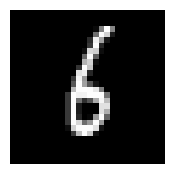

In [23]:
# The image to be displayed and tested 
i=27

#plot the image

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1],cmap="gray",aspect='auto')

#print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 1s 526ms/step


<BarContainer object of 10 artists>

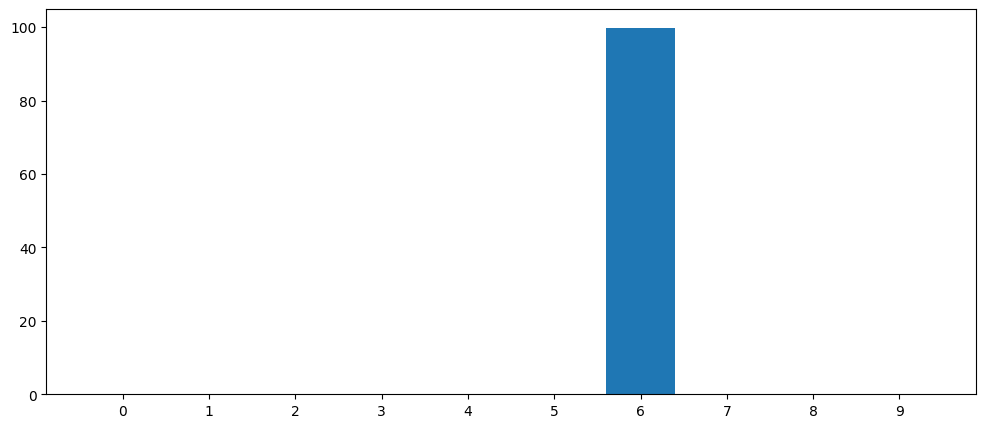

In [24]:
#obtain the model's predictions(logits)
predictions=model.predict(images_test[i-1:i])

#convert those predictions into probabilities(recall that we incorporated the softmax activation)
probabilities=tf.nn.softmax(predictions).numpy()

#convert the probabilities into percentages
probabilities=probabilities*100

#create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0],tick_label=["0","1","2","3","4","5","6","7","8","9"])

### Vusualising in Tensorboard

In [1]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### Computing the confusion matrix

In [3]:
import io
import itertools

In [4]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure